In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import transformer_lens

from probe_model import LinearProbe

In [2]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [3]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
def load_probe(ckpt_path):
    model = LinearProbe(device=device, num_input_features=768, num_classes=10)
    model.load_state_dict(torch.load(f"{ckpt_path}/checkpoint.ckpt", map_location=device))
    model.eval()
    return model

In [5]:
LAYER = 2
folder = f"ckpts/{model_name}/prewar_words10_133k/layer{LAYER}"
probe = load_probe(folder)

## Visualizing probe prediction per word in sample sentence

In [6]:
PREFIX = "Hello and welcome to my blog, where I love to list words.\nWhat "
prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

s_example = "This has two sentences. 98374598 + 238749872349 = 129381029, What will the probes find? Who knows it could be anything"
t_example = model.to_tokens(PREFIX + s_example, prepend_bos=True)

print(s_example)
print(t_example)

_, cache = model.run_with_cache(t_example, names_filter=lambda x: x.endswith("resid_post"))
residuals = cache.stack_activation("resid_post")
residuals = residuals[:, :, prefix_len:, :]
residuals.shape

This has two sentences. 98374598 + 238749872349 = 129381029, What will the probes find? Who knows it could be anything
tensor([[50256, 15496,   290,  7062,   284,   616,  4130,    11,   810,   314,
          1842,   284,  1351,  2456,    13,   198,  2061,   770,   468,   734,
         13439,    13,  9661,  2718,  2231,  4089,  1343,  2242,  5774,  2920,
          5774,  1954,  2920,   796, 20248,  2548,   940,  1959,    11,  1867,
           481,   262, 33124,  1064,    30,  5338,  4206,   340,   714,   307,
          1997]], device='cuda:0')


torch.Size([12, 1, 34, 768])

In [7]:
x_example = residuals.squeeze(1)

In [8]:
logits = probe(x_example[LAYER, :, :])

In [9]:
single_dir = logits[:, 0]
single_dir

tensor([  2.7443,  -6.1924,  -4.9303, -17.1612,  -4.9979,  -0.3876,  -3.5120,
         -3.3865,   1.5801,  -2.4498,  -7.1006,  -8.9150,  -6.7799,  -3.1363,
          2.4545,   0.3627,  -1.1416,  -9.1616,  -8.1765,  -1.8696,   0.2109,
         -5.5552,  -4.0887,  -6.3115,  -6.5153, -14.1650, -12.0600,  -0.7657,
          1.3845,  -4.6317,  -8.5808,  -7.7760, -10.5485,  -7.7368],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [10]:
token_idxs = t_example[0][prefix_len:]
token_strs = [model.to_single_str_token(tid.item()) for tid in token_idxs]
token_strs

[' This',
 ' has',
 ' two',
 ' sentences',
 '.',
 ' 98',
 '37',
 '45',
 '98',
 ' +',
 ' 23',
 '87',
 '49',
 '87',
 '23',
 '49',
 ' =',
 ' 129',
 '38',
 '10',
 '29',
 ',',
 ' What',
 ' will',
 ' the',
 ' probes',
 ' find',
 '?',
 ' Who',
 ' knows',
 ' it',
 ' could',
 ' be',
 ' anything']

In [11]:
val_range = (torch.min(single_dir), torch.max(single_dir))
vals = (single_dir - val_range[0]) / (val_range[1] - val_range[0])
vals = vals.detach().cpu().numpy()

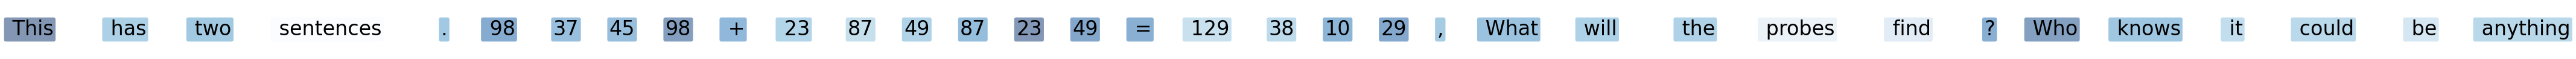

In [12]:
# Create a color map
cmap = plt.cm.Blues

# Setup the figure and axis
ax: plt.Axes
fig, ax = plt.subplots(figsize=(3, 1))
ax.axis('off')

# Initial coordinates
x_offset = 0.0
y_offset = 0.5  # Centered on y-axis

# Plot each token
for token, value in zip(token_strs, vals):
    # Add color block behind text
    bbox_props = dict(boxstyle="round,pad=0.1", facecolor=cmap(value), edgecolor='none', alpha=0.5)
    ax.text(x_offset, y_offset, token, ha="left", va="center", bbox=bbox_props, fontsize=24)
    
    # Update x_offset for the next token
    text_width = (len(token) + 2) * 0.1  # Approx width of each character in fontsize 14
    x_offset += text_width

plt.show()

## Cosine similarity within probe

In [13]:
LAYER = 3
folder = f"ckpts/{model_name}/randwords_631k/layer{LAYER}"
probe = load_probe(folder)

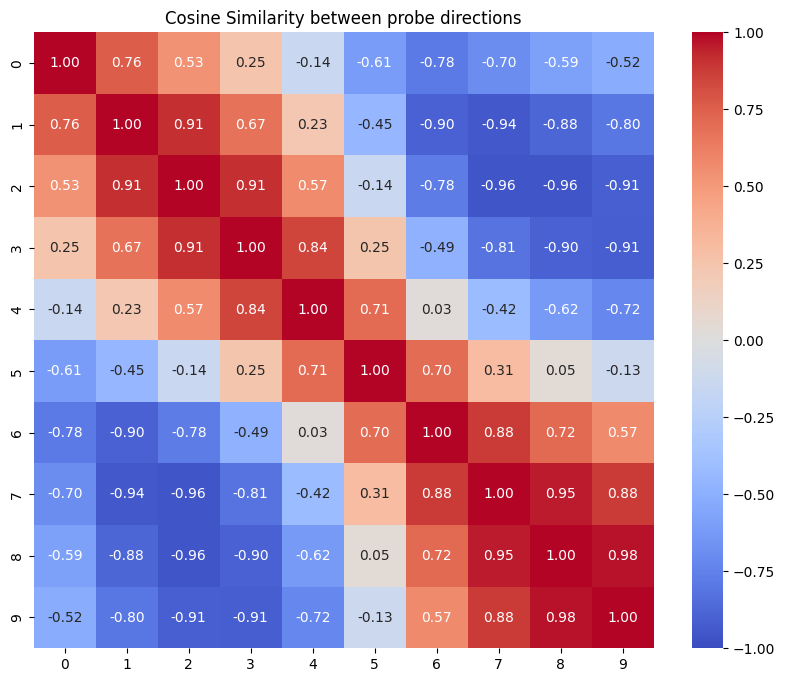

In [14]:
import seaborn as sns


def compute_cosine_similarity(matrix):
    # Normalize the rows to get the direction vectors
    norm_matrix = matrix / matrix.norm(dim=1, keepdim=True)
    # Compute cosine similarity
    similarity = torch.mm(norm_matrix, norm_matrix.t())
    return similarity

def visualize_similarity(similarity_matrix):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    ax.set_title('Cosine Similarity between probe directions')
    plt.show()


weights = probe.linear.weight.data

# Compute the cosine similarity matrix
cosine_similarity = compute_cosine_similarity(weights).cpu().numpy()

# Visualize the cosine similarity matrix
visualize_similarity(cosine_similarity)
